# Deep learning for Computer Vision - Final Project

- Andrea Borsani - **3012220**
- Vittorio Colombo - **3009107**
- Clara Marioni - **3007455**
- Silvia Nuti - **1831031**

## Table of contents <a name="tocs"></a>

- [1. Business idea](#business_idea)
- [2. Imports](#imports)
- [3. Web scraping](#web_scraping)
- [4. Image classification](#img_class)
    - [4.1. Model selection](#model_selection)
    - [4.2. VGG16 - Augmented or not augmented?](#data_aug)
    - [4.3. VGG16 - The model](#model)
    - [4.4. Evaluation of performance](#evaluation)
- [5. Style transfer](#style_transfer)
- [6. Possible ameliorations](#further)
- [7. References](#references)

## 1. Business idea <a name="business_idea"></a>

Within the vast scope of application of neural networks for computer vision, what captured our attention after much brainstorming was the possibility to cathegorize paintings according to the correspondent artistic movement. 

Even if at first this may not seem to provide a real business application it really goes deeper than what one would normally expect. For instance, the topic not only gives us the possibility to implement **image classification** and a **generative model**, but both these perspectives also have a **"real world" application**. More precisely, on the one hand, the recognition of the artistic movement from the picture of a painting can indeed be relevant if we put ourselves in the framework of museums, for example; indeed, this procedure could be helpful for a museum digital guide - which would allow the user to take a picture of the painting and be able to aknowledge the artistic movement - and even, if it is the case, for a specific app, following the same rationale of the user aiming at learning more about the painting he/she discovers. On the other, the generative model allows the user to apply a specific artistic style as a filter to his/her own picture, which in such a digital and social world can turn out being very handy and peculiar. In this sense, this technology could be implemented in a specific "filter app" or, potentially, even by the greatest competitors in the market (namely Instagram, Facebook, ecc).

In the next sections of this report, our work will be displayed and explained under a more technical perspective following the different steps we complied to, namely the web scraping procedure we used to gather the data (in [section 3](#web_scraping)), the neural network which classifies the paintings according to the artistic movement ([section 4](#img_class)) and, finally, the style transfer generative model, which allowed us to transpose the style of artistic movements upon a picture ([section 5](#style_transfer)). Eventually, one last section will outline the possible improvements which could be implemented in the models and which were here found to be out of scope or of time constraints ([section 6](#further)).

[Go back to top](#tocs)

## 2. Imports <a name="imports"></a>

In [11]:
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# image classification
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model

# model accuracy
from sklearn.metrics import classification_report, confusion_matrix

[Go back to top](#tocs)

## 3. Web scraping <a name="web_scraping"></a>

First step in our project is to gather the data we will need to train the models; hence, we need paintings! In order to collect them we accessed the website ["copia-di-arte.com"](https://www.copia-di-arte.com/) and through the web scraping procedure we downloaded the images. 

Please, to examine the code have a look at the [Web scraping](Web_scraping) folder we provided. There you will find the code, the outputs and a README.txt file which explains in detail the stages we implemented to reach our objective.

Eventually, we scraped 16.000 images belonging to 8 art movements - *Arte concreta figurativa*, *Barocco*, *Classicismo*, *Espressionismo*, *Impressionismo*, *Post-impressionismo*, *Rinascimento* and *Romanticismo*- which were divided into the three sets - train, test and validation - needed for the model training, with respective proportions of 0.7, 0.1, 0.2.

Then, after manually validating the images and eliminating the frames (which could have created problems during the training phase), we end with 11.153 paintings ready to be fed to the neural network. Please refer to the next section for this implementation.

**NB**: Please mind that we provided you with the images we used in the image classification procedure in the folder "Data", so that you do not have to run the web scraping unless you want to.

[Go back to top](#tocs)

## 4. Image classification <a name="img_class"></a>

In order to proceed with the image classification, two more steps were needed:
- Decide which movements to include in the model
- Decide which model to use

In the manual check of the images we noticed that some artistic movements were very similar: therefore, in order to obtain a more accurate classifier, we decided to drop *Barocco* and *Post-Impressionismo*, thinking that the algorithm would not have been able to discern among these classes.

Turning to the second point, we decided to rely on pre-trained networks using the already-trained weights, and fine-tuning only the last Dense layer. We tried out 3 different existing architechtures, in particular:

**- DenseNet**

**- VGG16**

**- VGG19**

At the same time, we tried to find the best combination of hyperparameters in terms of validation accuracy, without overfitting too much the train dataset. In particular, we focused on the last dense layer's size, the learning rate, the batch size, the dropout rate and the number of epochs. We also tried to add an l1 and l2 regularization on the Dense layer with very small values (around 0.0001) but we did not get any kind of improvement.

### 4.1 Model selection <a name="model_selection"></a>

After some trial and error, we discarded the DenseNet architechture because it was too much prone to overfitting. On the contrary, VGG16 and VGG19 reached better and similar levels of accuracy, so we focused on these two. Below you can find a comparison between the performance of VGG19 versus VGG16.

In [2]:
cwd = os.getcwd()
os.chdir(cwd+'/logs')

# MERGING ALL LOGS OF ALL MODELS
df = pd.DataFrame()
for file in os.listdir():
    if '.csv' in file:
        try:
            temp = pd.read_csv(file)
            temp['model'] = [file] * len(temp)
            df = df.append(temp)
        except:
            pass
        
os.chdir(cwd)

# PICKING THE BEST MODEL (on validation accuracy)
best_model = df[df.val_acc == df.val_acc.max()].model.values[0]

# we have to compare the 2 models but VGG19 has 100 epochs so we need to filter VGG16 for the same number of epochs
best_model_log = df[(df.model == best_model) & (df.epoch <= 99)]
vgg19 = df[df.model.str.contains("VGG19_2")]

def model_comparison(df1, df2, first_name, second_name):
    
    graph_title = f"{first_name} vs. {second_name}" # combining the two names in the graph title
    x = [i for i in range(max([df1.epoch.max(), df2.epoch.max()])+1)] # the number of epochs
    train_acc1 = df1.acc.tolist() # train accuracy of VGG16
    val_acc1 = df1.val_acc.tolist() # validation acc of VGG16
    
    # same for VGG19
    train_acc2 = df2.acc.tolist()
    val_acc2 = df2.val_acc.tolist()
    
    # setting the graph
    plt.figure(figsize=(12, 10))
    plt.title(graph_title, size=25)
    plt.xlabel("epochs", size=15)
    plt.ylabel("accuracy", size=15)
    
    # plotting the VGG16 model
    ax = sns.lineplot(x=x, y=train_acc1, linewidth=3, color="b") # train accuracy
    ax = sns.lineplot(x=x, y=val_acc1, linewidth=3, color="b") # validation accuracy
    
    # plotting the VGG19 model
    ax = sns.lineplot(x=x, y=train_acc2, linewidth=3, color="r") # train accuracy
    ax = sns.lineplot(x=x, y=val_acc2, linewidth=3, color="r") # validation accuracy
    
    # validation lines are dashed
    ax.lines[1].set_linestyle(":")
    ax.lines[3].set_linestyle(":")
    
    # manually setting the legend
    red_patch = mpatches.Patch(color='b', label=f'{first_name} (validation dashed)')
    blue_patch = mpatches.Patch(color='r', label=f'{second_name} (validation dashed)')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

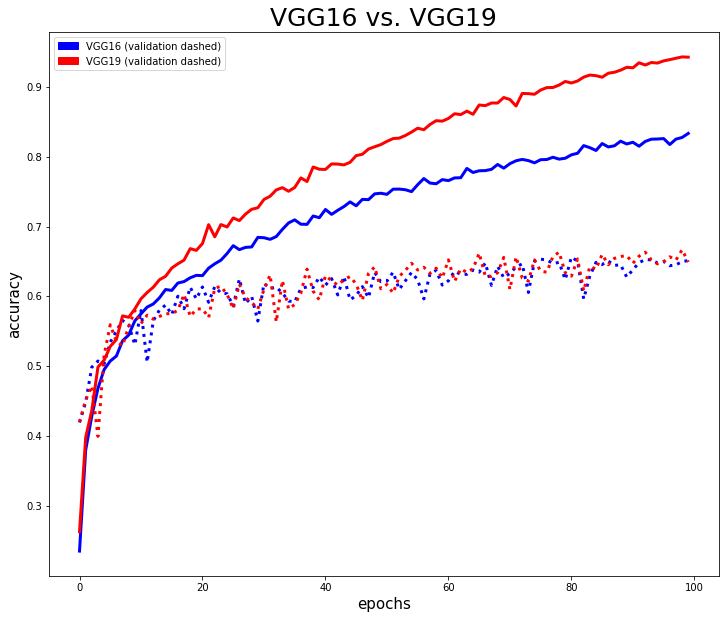

In [3]:
model_comparison(best_model_log, vgg19, first_name="VGG16", second_name="VGG19")

By analyzing the performance of the models, we concluded that even though VGG16 and VGG19 reached the same level of validation accuracy, VGG19 was probably overfitting the training data, and we thought that VGG16 was the best performing model and had a higher possibility to improve. Hence, we focused on it and repeated the tuning procedure. Eventually, we obtained the set of parameters which was able to return the most accurate outcome, namely:

**- batch size = 32**

**- learning rate = 1e-5**: smaller values led to a too slow network, while higher values overfitted too much the train data

**- dropout rate = 0.3**: we noticed that the model was particularly sensitive to the dropout rate, in the sense that usual dropout rates of 0.4 and 0.5 limited the model around a validation accuracy of 55%

**- Number of epochs**: our best performing model reaches a good enough accuracy after 80 epochs (more or less). After that, it does not show significant improvements. Since it was just the model selection part, we let the model run with 400 epochs and an early stopping after 80 epochs in case the model had not shown high enough improvements (+0.001) on the validation accuracy. Since the model stopped at the 288th epoch, we concluded that around the 200th epoch there was not more room for improvement. Thus, we ran our definitive model with **250 epochs** and a smaller **early stopping rule of 50.** 

### 4.2. VGG16 - Augmented or not augmented? <a name="data_aug"></a>

Eventually, one last thing we tried turned out to be the most curious one: we noticed that, applying **Image Augmentation** to our train dataset (hence fitting the model on a higher number of images), our model was suddenly underfitting: neither the train accuracy nor the validation accuracy were able to go beyond a 59-60%, as it can be seen from the graph below.

In [4]:
img_aug_yes = df[df.model == 'VGG16_150x150_epochs150_lr1e-05_dropout0.3_lastLsize2056.csv']
best_model_log2 = df[(df.model == best_model) & (df.epoch < len(img_aug_yes))]

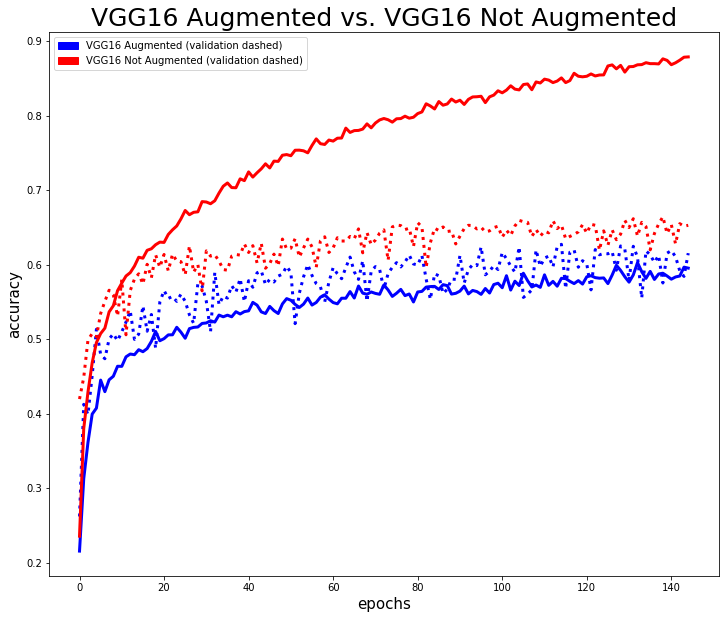

In [5]:
model_comparison(img_aug_yes, best_model_log2, first_name="VGG16 Augmented", second_name="VGG16 Not Augmented")

We can see that the model with augmented images reaches quite fast a good level of accuracy (around 60%), but then it does not improve at all. The model should have run until the 150th epoch but it stopped prematurely, even though we were very tolerant with the early stopping. The weirdest thing  is that the training data's curve does not improve at all and even trying with a higher number of epochs, a higher learning rate and a higher tolerance for early stopping, did not allow us to break the 60% accuracy wall. 

Our explanation is that we have built a good-enough network that still is not complex enough, and is not able to capture relevant patterns in the training data. While the model's simplicity works fine with a relatively small dataset, it creates underfitting problems on a higher amount of data. Even though we could have tried out more complex models, with a higher number of neurons in the last Dense layer or with more Convolutional and Dense layers, we decided that it was not worth it for computational reasons.

Therefore, we stuck with our VGG16 without Image Augmentation, that performs well enough according to us.

### 4.3. VGG16 - The model <a name="model"></a>

Hereby, we show the code we ran to perform the image classification procedure, as said, through the VGG16 architecture.

**NB**: Please, mind that we have provided you already with the saved model that we obtained during trial, hence you can directly go to [following section](#evaluation) for the model evaluation without running the following cell. If instead you want to run it, please uncomment the last line, otherwise it will not save the model.

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

warnings.simplefilter('ignore')

main_dir = os.getcwd()
train_dir = f"{main_dir}/Data/Train"
validation_dir = f"{main_dir}/Data/Validation"
test_dir = f"{main_dir}/Data/Test"

num_of_train_samples = 0
num_of_val_samples = 0
num_of_test_samples = 0

os.chdir(validation_dir)
for directory in os.listdir():
    os.chdir(validation_dir + "/" + directory)
    num_of_val_samples += len(os.listdir())
    os.chdir(validation_dir)

os.chdir(train_dir)
for directory in os.listdir():
    os.chdir(train_dir + "/" + directory)
    num_of_train_samples += len(os.listdir())
    os.chdir(train_dir)
    
os.chdir(test_dir)
for directory in os.listdir():
    os.chdir(test_dir + "/" + directory)
    num_of_test_samples += len(os.listdir())
    os.chdir(test_dir)

os.chdir(main_dir)

# PARAMETERS
img_rows = 150
img_cols = 150
batch_size = 32
epochs = 250
learning_rate = 1e-5
dropout_rate = 0.3
l1_regularization = 0.0
l2_regularization = 0.0
stop_patience = epochs // 5
last_layer_size = 2056
num_classes = 6
img_aug = 'no'

OUTPUT_NAME = f'''./logs/VGG16_{str(img_rows)}x{str(img_cols)}_imgaug{img_aug}_epochs{str(epochs)}_lr{str(learning_rate)}_dropout{str(dropout_rate)}_lastLsize{str(last_layer_size)}.csv'''

# MODEL
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_rows, img_cols, 3)
                  )
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(data_format='channels_last'))
model.add(layers.Dropout(rate=dropout_rate, seed=777))
model.add(layers.Dense(last_layer_size, 
                       activation='relu',
                       kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization))
                       )     
model.add(layers.Dense(num_classes, 
                activation='softmax',
                kernel_regularizer=regularizers.l1_l2(l1=l1_regularization, l2=l2_regularization))                       )

# COMPILING
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

# CALLBACKS
earlystop = EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=stop_patience,
    verbose=1,
    baseline=0.5,
    mode='auto'
)

csv_logger = CSVLogger(OUTPUT_NAME,
                       separator=',',
                       append=False)

# DATA
if img_aug == 'yes':
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
else:
    train_datagen = ImageDataGenerator(rescale=1. / 255)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

# FIT
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_of_train_samples // batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=num_of_val_samples // batch_size,
                              callbacks=[earlystop, csv_logger],
                              verbose=2)

model.save("our_best_vgg16.h5") 

### 4.4. Evaluation of performance  <a name="evaluation"></a>

One first step in evaluating the performance of our model is to have a look at the classification report - so basically a summary of how well we did in predicting the classes in the test set:

**NB**: Please change the name of the model at line 54 if you have run your own version of the model.

In [6]:
def plot_confusion_matrix(y_true, y_pred, target_names, normalize="yes", data=str):
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize == "yes":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for i in range(len(cm)):
            for j in range(len(cm[i])):
                cm[i][j] = round(cm[i][j], 2)
    else: 
        pass
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, cmap="PuBu")
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=target_names, 
           yticklabels=target_names,
           ylim=(-0.5,5.5))

    ax.set_title(f"{data} Confusion Matrix", size=25)
    ax.set_ylabel('True label', size=20)
    ax.set_xlabel('Predicted label', size=20)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", size=15,
             rotation_mode="anchor")

    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", size=15)
    
    if normalize == "yes":
        thresh = 0.5
    else:
        thresh = 95

    for i in range(len(target_names)):
        for j in range(len(target_names)):
            if cm[i, j]>=thresh:
                color="w"
            else:
                color="k"
            ax.text(j, i, cm[i, j],
                        ha="center", va="center", size=13, 
                        color=color)

    plt.show()



warnings.simplefilter('ignore')

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

model = load_model("our_best_vgg16.h5") 
model.summary()

main_dir = os.getcwd()

validation_dir = f"{main_dir}/Data/Validation" # ATTENTION HERE
test_dir = f"{main_dir}/Data/Test" # ATTENTION HERE

img_rows = 150
img_cols = 150
batch_size = 32

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_rows, img_cols),
                                                  batch_size=batch_size, 
                                                  class_mode='categorical',
                                                  shuffle=False)

# THE LABELS

# true ones
y_true_val = validation_generator.classes # validation
y_true_test = test_generator.classes #test

print("Done with true labels")

# predicted ones
# validation
Y_pred_val = model.predict_generator(validation_generator, steps=len(validation_generator))
y_pred_val = np.argmax(Y_pred_val, axis=1)
print("Done with val pred")

#test
Y_pred_test = model.predict_generator(test_generator, steps=len(test_generator))
y_pred_test = np.argmax(Y_pred_test, axis=1)
print("Done with test pred")

# names of the classes: they are the same for all three datasets! 
target_names = list(validation_generator.class_indices.keys())

print("""
                          ===============================
                          Test Set Classification Report:
                          ===============================
""")
print(classification_report(y_true_test, y_pred_test, target_names=target_names, digits=3))

W1126 16:46:46.630366 139711865259840 deprecation.py:506] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1126 16:46:46.633799 139711865259840 deprecation.py:506] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1126 16:46:46.636476 139711865259840 deprecation.py:506] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2056)              16844808  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12342     
Total params: 31,571,838
Trainable params: 16,857,150
Non-trainable params: 14,714,688
_________________________________________________________________
Found 2272 images belonging to 6 classes.
Found 1137 images belonging to 6 classes.
Done with true la

From the report we can immediately obtain a direct measure of performance in the **recall** value; logically, the higher the value the greater the performance, hence we can already see which artistic movements we managed to classify better and which ones instead show a little poorer perfomance.

However, before commenting on the results, we can do a step further and try to visualize them even better via a **confusion matrix**:

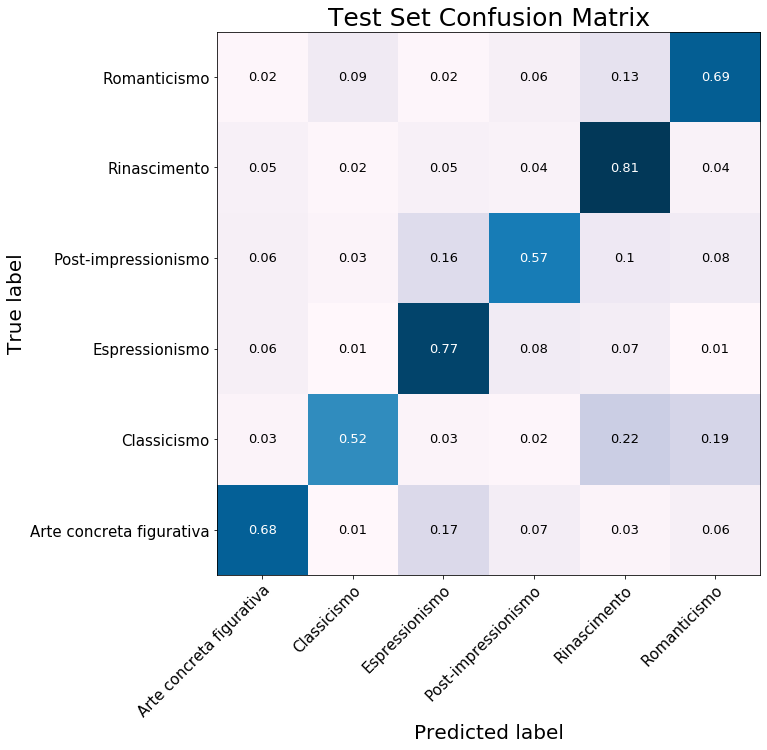

In [7]:
plot_confusion_matrix(y_true_test, y_pred_test, target_names, normalize='yes', data="Test Set")

The confusion matrix above shows the True positive rate, alongside with the proportions of missclassified samples.

On average, we performed well on:

- **"Rinascimento"**, with a recall of 81%

- **"Espressionismo"**, with a recall of 77%

- **"Romanticismo"**, with a recall of 69% 

- **"Arte concreta figurativa"**, with a recall of 68%, the smallest within the best since the model seems to have a little more trouble in distinguishing between this movement and the "Espressionismo" one. However, it still delivers a satisfactory overall score.

As far as **"Post-impressionismo"** and **"Classicismo"** are concerned, the performance is poorer, since the recall scores reach, respectively, 57% and 52%. For instance, looking at the matrix, we can clearly see how the *Post-impressionismo*'s paintings are classified as *Espressionismo* and how the *Classicismo* paintings are sometimes categorized as *Rinascimento* or *Romanticismo*. Even though we are not completely satisfied with the result, we were at least able to explain this: in the former case, the two movements include artists who had very similar styles, being very close time-wise speaking. In the latter case, the rationale is the same, since *Classicismo* and *Rinascimento* mainly share the style and the pictorial trait, while *Classicismo* and *Romanticismo* share very similar subjects. Consequently, it is reasonable to think that the model has some kind of difficulties in distinguishing the movements, hence dmaging the performance. Below there's an example of misclassified images, in order to show you what we just imputed:

In [8]:
table = pd.DataFrame({'image': test_generator.filepaths, 
                      'true': y_true_test, 
                      'pred': y_pred_test})

In [9]:
def show_images(class1:str, class2:str, n_samples:int):
    
    index_cl1 = test_generator.class_indices[class1]
    index_cl2 = test_generator.class_indices[class2]
    try:
        missclassified_1 = table[(table.true==index_cl1) & (table.pred==index_cl2)].image.sample(n=n_samples).reset_index().iloc[:,1:].image.tolist()
    except ValueError:
        missclassified_1 = table[(table.true==index_cl1) & (table.pred==index_cl2)].image.sample(n=n_samples, replace=True).reset_index().iloc[:,1:].image.tolist()
    try:
        missclassified_2 = table[(table.true==index_cl2) & (table.pred==index_cl1)].image.sample(n=n_samples).reset_index().iloc[:,1:].image.tolist()
    except ValueError:
        missclassified_2 = table[(table.true==index_cl2) & (table.pred==index_cl1)].image.sample(n=n_samples, replace=True).reset_index().iloc[:,1:].image.tolist()

    first_class = table[(table.true==index_cl1)].image.sample(n=n_samples).reset_index().iloc[:,1:].image.tolist()
    second_class = table[(table.true==index_cl2)].image.sample(n=n_samples).reset_index().iloc[:,1:].image.tolist()

    images = [[missclassified_1[i], missclassified_2[i], first_class[i], second_class[i]] for i in range(n_samples)]

    fig, ax = plt.subplots(n_samples, 4, figsize=(15, 12))

    for i in range(n_samples):
        for j in range(4):
            img = Image.open(images[i][j])
            ax[i, j].imshow(img)

    ax[0, 0].set_title(f"""Pred {class1}, \n true {class2}""", size=20)
    ax[0, 1].set_title(f"Pred {class2}, \n true {class1}", size=20)
    ax[0, 2].set_title(f"{class1}", size=20)
    ax[0, 3].set_title(f"{class2}", size=20)
    
    
    plt.subplots_adjust(top=0.2) 
    plt.tight_layout()
    plt.show()


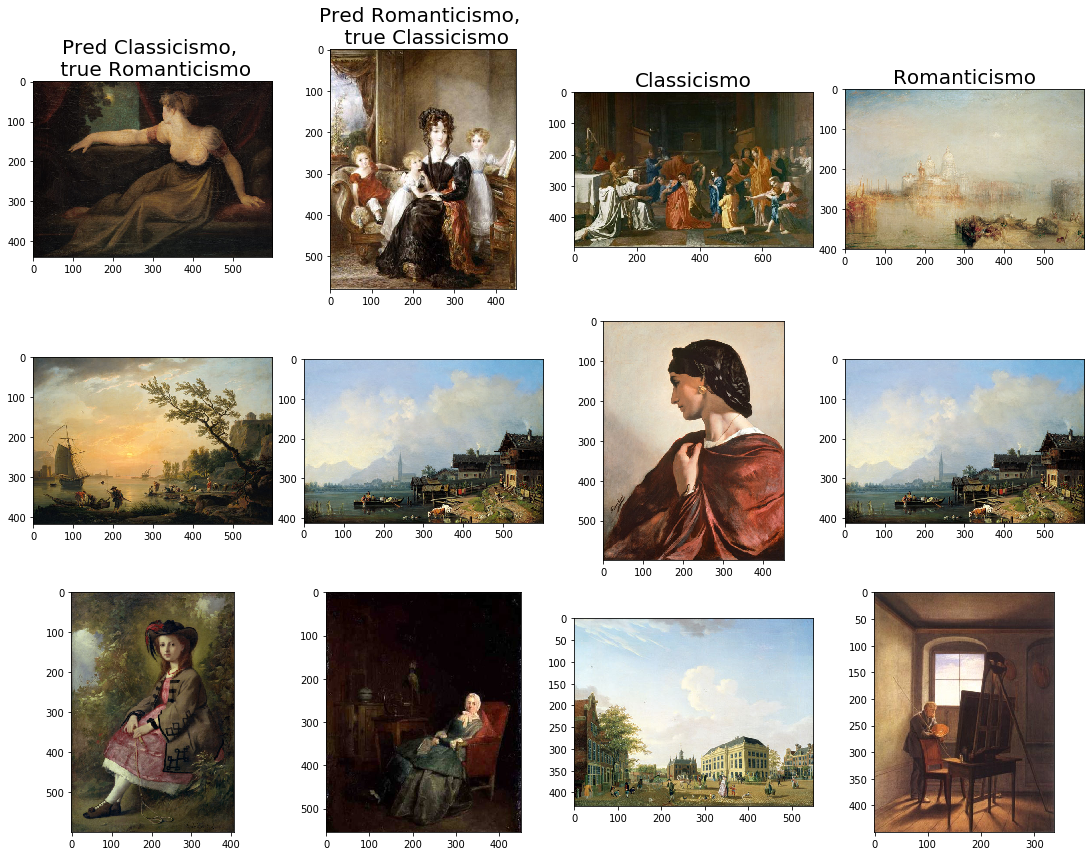

In [10]:
show_images(class1="Classicismo", class2="Romanticismo", n_samples=3)

[Go back to top](#tocs)

## 5. Style transfer  <a name="style_transfer"></a>

After the classification of paintings, another idea which came to our minds was the one of trying to apply the various artistic movements (i.e. their pictorial style) to an external image chosen by the user. The business potential behind this has already been depicted, so now we can move to the technical part, the code.

Mind that you can choose any picture as the target you want to apply the style transfer to, but for consistency we provided you with the ones we have used while training the model (in the folder "images"). In the same folder you can as well find the paintings we used to obtain the styles to be transfered; it goes without saying that you can choose whichever other painting you like. You simply should define it in the code.

**NB**: running this code on the server could raise an error regarding a problem with different versions of cuDNN and of tensorflow-gpu; if that is the case, please go to the [style_transfer](style_transfer) folder and run the .py file.

In [12]:
#style transfer
import tensorflow.keras
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
import time

#load images
reference_name = "espressionismo.jpeg" #the painting from which you want to transfer the style from
target_name = "leo.jpeg" # the image on which you want to apply the style

reference_image_path = os.getcwd()+'/images/reference/'+reference_name
target_image_path = os.getcwd()+'/images/target/'+target_name

# allow memory growth and manage memory allocation
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# creating the folder in which results are stored
all_files = os.listdir()
out_folder_name = f'from_{reference_name[:-5]}_to_{target_name[:-5]}'
existing_folders=[int(file[-1]) for file in all_files if out_folder_name in file] # list of last iterations
if len(existing_folders) == 0: # if there are no files, make the directory
    final_directory = os.getcwd()+'/'+out_folder_name+'_0'
    os.mkdir(final_directory)
else:    
    max_trial = max(existing_folders)
    new_folder_index = max_trial+1
    out_folder_name += f'_{str(new_folder_index)}'
    final_directory = os.getcwd()+'/'+out_folder_name
    os.mkdir(final_directory)

# Choose the style and dimension of the resulting image
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939       
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, :img_height - 1, 1:, :])
    
    return K.sum(K.pow(a + b, 1.25))

target_image = K.constant(preprocess_image(target_image_path))
reference_image_path = K.constant(preprocess_image(reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3)) # placeholder that will contain the generated image

input_tensor = K.concatenate([target_image, reference_image_path, combination_image], axis=0) # concatenating 3 imgs in a single batch

model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
print("Model loaded.")

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025
# loss: content loss and tot variation loss
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features,
                   combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

# grad descend

grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
        
evaluator = Evaluator()

result_prefix = '/my_result'
iterations = 100

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    
    print('Current loss value:', min_val)
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    img = Image.fromarray(img)
    fname = final_directory + result_prefix + f'_iter{i}.jpg'
    
    img.save(fname)
    print('Image saved as', fname)
    end_time = time.time()
    print(f'Iteration {i} completed in {end_time - start_time} seconds.')

Model loaded.


W1126 17:11:18.131797 139711865259840 deprecation.py:323] From /usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Start of iteration 0
Current loss value: 1346016000.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter0.jpg
Iteration 0 completed in 4.0734429359436035 seconds.
Start of iteration 1
Current loss value: 597186600.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter1.jpg
Iteration 1 completed in 2.7878434658050537 seconds.
Start of iteration 2
Current loss value: 389947500.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter2.jpg
Iteration 2 completed in 2.7651751041412354 seconds.
Start of iteration 3
Current loss value: 309122340.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter3.jpg
Iteration 3 completed in 2.5036375522613525 seconds.
Start of iteration 4
Current loss value: 259893230.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter4.jpg
Iteration 4 completed in 2.6799585819244385 seconds.
Start of iteration 5
Current loss value: 230

Current loss value: 82520890.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter43.jpg
Iteration 43 completed in 2.7880232334136963 seconds.
Start of iteration 44
Current loss value: 81464590.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter44.jpg
Iteration 44 completed in 2.7723944187164307 seconds.
Start of iteration 45
Current loss value: 80829300.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter45.jpg
Iteration 45 completed in 2.667360782623291 seconds.
Start of iteration 46
Current loss value: 80080390.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter46.jpg
Iteration 46 completed in 2.966358184814453 seconds.
Start of iteration 47
Current loss value: 79375656.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter47.jpg
Iteration 47 completed in 2.7587883472442627 seconds.
Start of iteration 48
Current loss value: 78614110.0
Image 

Current loss value: 63578692.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter86.jpg
Iteration 86 completed in 3.003302574157715 seconds.
Start of iteration 87
Current loss value: 63248950.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter87.jpg
Iteration 87 completed in 2.9945123195648193 seconds.
Start of iteration 88
Current loss value: 62920044.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter88.jpg
Iteration 88 completed in 3.256784200668335 seconds.
Start of iteration 89
Current loss value: 62591148.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter89.jpg
Iteration 89 completed in 3.3248984813690186 seconds.
Start of iteration 90
Current loss value: 62337456.0
Image saved as /home/1831031/silvia/from_espressionismo_to_leo_0/my_result_iter90.jpg
Iteration 90 completed in 3.1824450492858887 seconds.
Start of iteration 91
Current loss value: 62094424.0
Image 

In this specific case we have transferred the style of the famous painting "Viandante sul mare di nebbia" di C.D. Friedrich on a picture of a landscape; the loss value has decreased iteration by iteration, creating a pretty satisfying result. 

**NB**: Mind that the number of iterations can be increased even further, even if the change from the 100th one happens but much more slowly.

[Go back to top](#tocs)

## 6. Possible ameliorations <a name="further"></a>

As a matter of fact, this project has tried to implement neural networks to computer vision, but it cannot be said that the work here is completely done. For instance there are possible improvements which could be implemented to, on the one hand, increase difficulty and reach completeness, and, on the other, to better train the models and increase the accuracy. First of all, the accuracy of the VGG16 architecture could be boosted by trying to apply **feature extraction** procedure (even if it has the downside of eliminating the possibility of applying data augmentation). 

Secondly, it would of course be possible to enlarge the number of classes (i.e. include more artistic movements into the big picture), but this must be done coherently with the model and running power.

Finally, another idea could be not to stop at the artistic movement, but instead classify paintings on the basis of the author, or the date, or the dimensions. Certainly, it would not be easy to implement (increasing the risk of complicating too much the model) but it would be an incredible boost if we re-put ourselves in the framework of the museum guide - which would, in this case, display all the useful information of a painting directly froma picture made by the user. 

In conclusion, this work has been really interesting and has allowed us to enter in a continuosly changing very fascinating world, but it is known it could be brought even further with some new implementations.

[Go back to top](#tocs)

## 7. References <a name="references"></a>

- J. Yang, L. Chen, L. Zhang, X. Sun, D. She, S. Lu, M. Cheng (October 22-26, 2018). **"Historical Context-based Style Classification of Painting Images via Label Distribution Learning"**. College of Computer Science, Nankai University, Tianjin, China. Advanced Digital Sciences Center, Illinois at Singapore.  
- K. Abe, B. Saleh, A. Elgammal (2013). **"An Early Framework for Determining Artistic Influence"**. Department of Computer Science Rutgers University.
- B. Saleh, K. Abe, R. S. Arora, A. Elgammal (2014). **"Toward automated discovery of artistic influence"**. Springer Science+Business Media New York 2014.
- T. W. (Sep 24th, 2013). **"How do you spot a real Van Gogh"**. The Economist Explains.
- S. Lee, E. Cha (2016). **"Style classification and visualizationof art painting’s genre using self‐organizing maps"**. Human-centric Computing and Information Sciences.
- F. Chollet (2017). **"Deep Learning with Python"**. Manning Shelter Island.
- E. Cetinic, T. Lipic, S. Grgic (2018).**"Fine-tuning convolutional neural networks for fine art classification"**.
- N. Viswanathan (2018). **"Artist identification with convolutional neural networks"**.

[Go back to top](#tocs)